In [14]:
import pandas as pd
import pymongo
from pymongo import MongoClient

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']
metadata_coll = db.metadata

In [15]:
movie_rates_df = pd.DataFrame(metadata_coll.find({},{'_id':'_id', 'vote_average':'vote_average','vote_count':'vote_count'}))
movie_rates_df = movie_rates_df.rename(columns={'_id':'movie_id'})
movie_rates_df = movie_rates_df.loc[movie_rates_df['vote_count'] >= 250]
movie_rates_df


,movie_id,vote_average,vote_count
0,862,7.7,5415.0
1,8844,6.9,2413.0
5,949,7.7,1886.0
9,710,6.6,1194.0
12,21032,7.1,423.0
...,...,...,...
44927,269795,5.5,277.0
44985,353491,5.7,688.0
45110,378236,5.8,327.0
45145,339692,6.9,324.0


In [16]:
import re
movie_rates_df.head()
movie_rates_df.dtypes
movie_ids_series = movie_rates_df['movie_id']
for index,value in movie_ids_series.items():
    new_value = ''.join(re.findall("\d+", value))
    movie_ids_series[index] = new_value

movie_rates_df['movie_id'] = movie_rates_df['movie_id'].astype(float)
movie_rates_df.dtypes


movie_id        float64
vote_average    float64
vote_count      float64
dtype: object

In [17]:

people_coll = db.people
actors_df = pd.DataFrame(people_coll.find( {'jobs': { '$in': ["Actor"]} },{'_id':'_id', 'name':'name'}))
actors_df


,_id,name
0,31,Tom Hanks
1,12898,Tim Allen
2,7167,Don Rickles
3,12899,Jim Varney
4,12900,Wallace Shawn
...,...,...
205790,1177500,Jason Widener
205791,93930,Kiko Ellsworth
205792,1686379,Darrell Dubovsky
205793,1261758,Aleksandr Chabrov


In [18]:
cast_coll = db.cast
cast_df = pd.DataFrame(cast_coll.find({},{'movie_id':'movie_id', 'person_id':'person_id'}))



In [19]:

#cast_df = cast_df.set_index('movie_id')
cast_df.dtypes


_id           object
person_id    float64
movie_id     float64
dtype: object

In [20]:
movies_actor_df = pd.merge(cast_df,movie_rates_df)
movies_actor_df = movies_actor_df.drop(columns='_id')
tmp1 = movies_actor_df.groupby(['movie_id','person_id'])
tmp1.first()


vote_average  vote_count
movie_id person_id                          
5.0      62.0                6.5       539.0
         138.0               6.5       539.0
         2545.0              6.5       539.0
         2555.0              6.5       539.0
         3122.0              6.5       539.0
...                          ...         ...
419430.0 1704626.0           7.2      2978.0
         1754534.0           7.2      2978.0
         1754535.0           7.2      2978.0
         1754536.0           7.2      2978.0
         1754537.0           7.2      2978.0

[96047 rows x 2 columns]

## Filtro attori in base al numero di film a cui hanno partecipato  

In [21]:
num_film = 0
num_film_actor_df = movies_actor_df.groupby('person_id').count().reset_index()
num_film_actor_df = num_film_actor_df.rename(columns={'vote_average':'num_film'})
num_film_actor_df = num_film_actor_df.drop(columns='movie_id')
num_film_actor_df = num_film_actor_df.loc[num_film_actor_df['num_film'] >= num_film]
actors_id_num_film = num_film_actor_df['person_id']
actors_id_num_film.head()


0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: person_id, dtype: float64

## Attori e media dei film a cui hanno partecipato

In [22]:
tmp = movies_actor_df.loc[movies_actor_df['person_id'].isin(actors_id_num_film)] 
actors_mean_rate_films = tmp.groupby('person_id').mean().reset_index().drop(columns=['movie_id','vote_count']).rename(columns=   {'vote_average':'vote_average_films'})

actors_mean_rate_films.head()

,person_id,vote_average_films
0,1.0,6.600000
1,2.0,7.414286
2,3.0,6.716129
3,4.0,6.864286
4,5.0,8.100000


In [23]:
#movies_actor_df.groupby(['movie_id','person_id']).first()
tmp2 = pd.merge(movies_actor_df, actors_mean_rate_films, on='person_id')
tmp3 = tmp2.groupby('movie_id').mean().reset_index().rename(columns={'vote_average_films':'cast_vote_average'}).drop(columns=['person_id','vote_count'])
tmp3.head(100)
tmp3.


,movie_id,vote_average,cast_vote_average
0,5.0,6.5,6.543554
1,11.0,8.1,7.880240
2,12.0,7.6,6.925247
3,13.0,8.2,7.715754
4,14.0,7.9,7.286435
...,...,...,...
95,177.0,7.2,6.949235
96,179.0,6.2,6.448375
97,180.0,7.1,6.651791
98,184.0,7.3,6.985190


Matplotlib is building the font cache; this may take a moment.


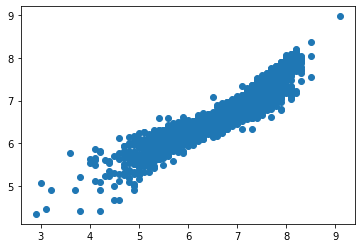

In [24]:
import matplotlib.pyplot as plt 
plt.scatter(tmp3.vote_average,tmp3.cast_vote_average)
